In [1]:
from collections import defaultdict
from scipy.ndimage import gaussian_filter
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import os
import numpy as np
import pygame
import pygame.gfxdraw

import pickle
# import Cython
# %load_ext Cython

pygame 2.0.2 (SDL 2.0.16, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


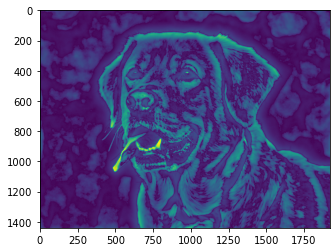

In [57]:
np.random.seed(0)

inp = pygame.surfarray.pixels3d(pygame.image.load("dog.jpg"))
perceptual_weight = np.array([0.2126, 0.7152, 0.0722])
grayscale = (inp * perceptual_weight).sum(axis=-1)
plt.imshow(grayscale.T);

x = gaussian_filter(grayscale, 2, mode="reflect")
x2 = gaussian_filter(grayscale, 30, mode="reflect")

# Take the difference, deweight negatives, normalise
diff = (x - x2)
diff[diff < 0] *= 0.1
diff = np.sqrt(np.abs(diff) / diff.max())

plt.imshow(diff.T)

In [58]:
# %%cython -a
# import numpy as np

def sample(ref, n=1_0_000):
    w,h  = x.shape
    xs = np.random.randint(0, w, size=n)
    ys = np.random.randint(0, h, size=n)
    value = ref[xs, ys]
    accept = np.random.random(size=n) < value
    points = np.array([xs[accept], ys[accept]])
    return points.T, value[accept]

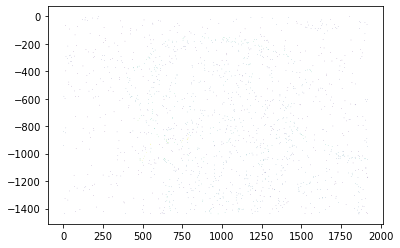

In [59]:
# %%timeit
samples, v = sample(diff)
plt.scatter(samples[:, 0], -samples[:, 1], c=v, s=0.2, edgecolors="none", cmap="viridis")

In [60]:

def get_colour_of_tri(tri, image):
    colours = defaultdict(lambda: [])
    w, h, _ = image.shape
    for i in range(0, w):
        for j in range(0, h):
            # Gets the index of the triangle the point is in
            index = tri.find_simplex((i, j))
            colours[int(index)].append(inp[i, j, :])
    # For each triangle, find the average colour
    for index, array in colours.items():
        colours[index] = np.array(array).mean(axis=0)
    return colours

In [61]:

def draw(tri, colours, screen, upscale):
    s = screen.copy()
    for key, c in colours.items():
        t = tri.points[tri.simplices[key]]
        pygame.gfxdraw.filled_polygon(s, t * upscale, c)
        pygame.gfxdraw.polygon(s, t * upscale, c)
    return s

In [62]:
w, h, _ = inp.shape
upscale = 2
screen = pygame.Surface((w * upscale, h * upscale))
screen.fill(inp.mean(axis=(0, 1)))
corners = np.array([(0, 0), (0, h - 1), (w - 1, 0), (w - 1, h - 1)])
points = np.concatenate((corners, samples))

outdir = "lowpoly/output/"
os.makedirs(outdir, exist_ok=True)

In [64]:
# n=0
# tri=None
# colours=None

# for i in range(0, 1):
# #     n = 5 + i + 2 * int(i**2)
#     n = 5 + 100 + 2 * int(100**2)
#     tri = Delaunay(points[:n, :])
#     colours = get_colour_of_tri(tri, inp)
#     s = draw(tri, colours, screen, upscale)
#     s = pygame.transform.smoothscale(s, (w, h))
#     pygame.image.save(s, f"lowpoly/output/{i:04d}.png")

nn = 20
n = 5 + nn + 2 * int(nn**2)
tri = Delaunay(points[:n, :])
colours = get_colour_of_tri(tri, inp)
s = draw(tri, colours, screen, upscale)
s = pygame.transform.smoothscale(s, (w, h))
pygame.image.save(s, f"lowpoly/output/{i:04d}.png")


In [40]:
array = np.array([
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
])

def fun(e):
    return e%2

vfunc = np.vectorize(fun)

result = vfunc(array)
result

array([[1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1]])